In [1]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import feather
import requests
import requests_cache
import lxml
from bs4 import BeautifulSoup
import bs4
import re
%matplotlib inline

In [ ]:
#%%timeit -r1 -n1 
# timeit args from: http://stackoverflow.com/questions/32565829/simple-way-to-measure-cell-execution-time-in-ipython-notebook 
# For some reason the varible isn't saved when using timeit

# Note: To just read in part add nrows =
parseDates = ["Opened", "Closed", "Updated"] # Convert these to datetimes
street_csv = pd.read_csv("Street_and_Sidewalk_Cleaning.csv", 
                         #nrows = 100000,
                         parse_dates=parseDates)


In [ ]:
feather.write_dataframe(street_csv, 'street.feather')

In [ ]:
# Similar thing built in to pandas. Causes some error.
street.to_hdf('street.h5','table',append=False)

In [2]:
#street2 = pd.read_hdf('street.h5')

In [2]:
street = feather.read_dataframe('street.feather')

In [4]:
# To use the csv version
# street = street_csv

In [6]:
#all(street == street_csv)

In [3]:
street.head()

,CaseID,Opened,Closed,Status,Responsible Agency,Address,Category,Request Type,Request Details,Source,Supervisor District,Neighborhood,Updated,Point
0,322566,2008-11-30 22:56:00,2009-07-21 16:24:00,Closed,DPW Ops Queue,"1566 HYDE ST, SAN FRANCISCO, CA, 94109",Street and Sidewalk Cleaning,Sidewalk_Cleaning,Garbage,Voice In,3.0,Nob Hill,2009-07-21 16:24:00,"(37.795328529, -122.418067787)"
1,322560,2008-11-30 22:24:00,2009-07-21 16:24:00,Closed,DPW Ops Queue,Intersection of TAYLOR ST and TURK ST,Street and Sidewalk Cleaning,Illegal_Dumping,Garbage,Voice In,6.0,Downtown/Civic Center,2009-07-21 16:24:00,"(37.7832142923006, -122.410764953722)"
2,322559,2008-11-30 22:20:00,2008-12-01 06:07:00,Closed,DPW Ops Queue,"1601 SACRAMENTO ST, SAN FRANCISCO, CA, 94109",Street and Sidewalk Cleaning,Illegal_Dumping,Mattress,Voice In,3.0,Nob Hill,2008-12-01 06:07:00,"(37.791643509125, -122.419260423291)"
3,322556,2008-11-30 21:34:00,2008-12-09 08:07:00,Closed,DPW Ops Queue,Intersection of 25TH ST and LUCKY ST,Street and Sidewalk Cleaning,Sidewalk_Cleaning,Human_waste_or_urine,Voice In,9.0,Mission,2008-12-09 08:07:00,"(37.7509362479361, -122.413364630104)"
4,322545,2008-11-30 20:45:00,2009-02-03 07:09:00,Closed,DPW Ops Queue,Intersection of 19TH ST and OAKWOOD ST,Street and Sidewalk Cleaning,Sidewalk_Cleaning,Empty_cart,Voice In,8.0,Mission,2009-02-03 07:09:00,"(37.7598935230725, -122.42486308879)"


Some basic statistics on the dataset we are starting with:

In [4]:
numRows = street.shape[0]
print "We are working with", numRows, "rows."
print "Our dates range from", street.loc[numRows - 1, "Opened"],"to", street.loc[0, "Opened"], "."

We are working with 747388 rows.
Our dates range from 2017-01-22 00:26:01 to 2008-11-30 22:56:00 .


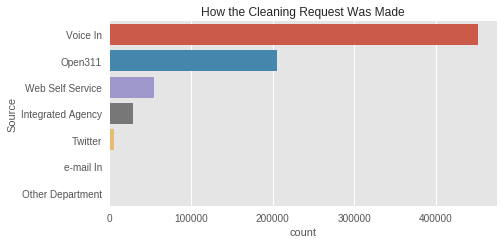

In [5]:
#plt.figure(figsize=(2,100)) # Doesn't do much
theOrder = ["Voice In", "Open311", "Web Self Service", "Integrated Agency", "Twitter", "e-mail In", "Other Department"]
#sns.set(font_scale = 1.5)
sns.set_context("notebook", rc={"font.size" : 40}) # font_scale=1.5
ax = sns.factorplot(y = "Source", data = street, kind = "count", orient = "h", order = theOrder, aspect = 2)#, size = 10)
plt.title("How the Cleaning Request Was Made") 
plt.show()

According to [the project's website](http://www.open311.org/learn/), Open311 allows people to report issues in public spaces to city officials through a [website](https://sf311.org/index.aspx?page=797) or [mobile app](https://www.sf311.org/mobile).  

In [6]:
street.Neighborhood.unique()

array(['Nob Hill', 'Downtown/Civic Center', 'Mission',
       'West of Twin Peaks', 'South of Market', 'Western Addition',
       'Outer Mission', 'Bernal Heights', 'Russian Hill', 'Outer Sunset',
       'Outer Richmond', 'Castro/Upper Market', 'Haight Ashbury',
       'Excelsior', 'Golden Gate Park', 'Ocean View', 'Bayview',
       'Crocker Amazon', 'Inner Richmond', 'Visitacion Valley',
       'Pacific Heights', 'North Beach', 'Parkside', 'Financial District',
       'Inner Sunset', 'Marina', 'Twin Peaks', 'Presidio Heights',
       'Potrero Hill', 'Chinatown', 'Noe Valley', 'Lakeshore', 'Seacliff',
       'Glen Park', 'Diamond Heights', 'Presidio', None,
       'Treasure Island/YBI', 'Telegraph Hill', 'Showplace Square',
       'Mission Dolores', 'Bret Harte', 'Panhandle', 'Duboce Triangle',
       'Dolores Heights', 'Mission Terrace', 'Polk Gulch',
       'Ashbury Heights', 'Civic Center', 'Cole Valley', 'Hunters Point',
       'Tenderloin', 'Mission Bay', 'Presidio Terrace', 'Cast

In [7]:
street.Neighborhood.value_counts

<bound method Series.value_counts of 0                      Nob Hill
1         Downtown/Civic Center
2                      Nob Hill
3                       Mission
4                       Mission
5                       Mission
6                       Mission
7                       Mission
8            West of Twin Peaks
9            West of Twin Peaks
10                      Mission
11              South of Market
12             Western Addition
13                Outer Mission
14               Bernal Heights
15                     Nob Hill
16              South of Market
17                      Mission
18                 Russian Hill
19                     Nob Hill
20        Downtown/Civic Center
21             Western Addition
22             Western Addition
23                 Outer Sunset
24                     Nob Hill
25               Outer Richmond
26              South of Market
27              South of Market
28          Castro/Upper Market
29          Castro/Upper Market
   

In [8]:
# From: http://stackoverflow.com/questions/22391433/count-the-frequency-that-a-value-occurs-in-a-dataframe-column
counts = street.groupby('Neighborhood').count()

We can get the total number of cases from CaseID
unresolved cases by neighborhood

In [9]:
counts = counts.sort_values(by = "CaseID",
                            ascending = False)
counts = counts.reset_index()

In [10]:
counts.head()

,Neighborhood,CaseID,Opened,Closed,Status,Responsible Agency,Address,Category,Request Type,Request Details,Source,Supervisor District,Updated,Point
0,Mission,103254,103254,101783,103254,103254,103254,103254,103242,103240,103254,103254,103254,103254
1,South of Market,70221,70221,69009,70221,70221,70221,70221,70215,70215,70221,70221,70221,70221
2,Tenderloin,29747,29747,29272,29747,29747,29747,29747,29746,29746,29747,29747,29747,29747
3,Bayview,28256,28256,27916,28256,28256,28256,28256,28256,28255,28256,28256,28256,28256
4,Downtown/Civic Center,27985,27985,27948,27985,27985,27985,27985,27985,27984,27985,27985,27985,27985


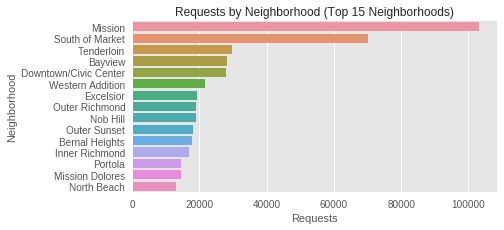

In [36]:
sns.set_context("notebook", rc={"font.size" : 40}) # font_scale=1.5
ax = sns.factorplot(x = "CaseID", 
                    y = "Neighborhood",
                    data = counts.head(15), 
                    kind = "bar", 
                    orient = "h", 
                    aspect = 2
                   )#, size = 10)
ax.set_xlabels("Requests")
plt.title("Requests by Neighborhood (Top 15 Neighborhoods)") 
plt.show()

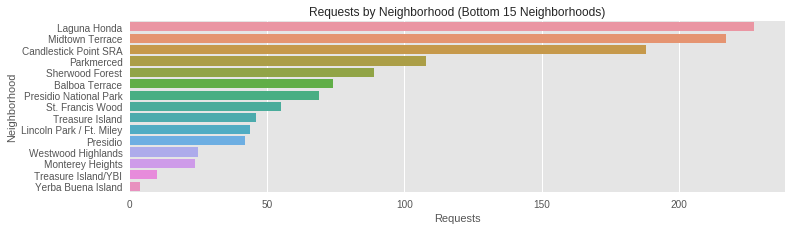

In [12]:
sns.set_context("notebook", rc={"font.size" : 40}) # font_scale=1.5
ax = sns.factorplot(x = "CaseID", 
                    y = "Neighborhood",
                    data = counts.tail(15), 
                    kind = "bar", 
                    orient = "h", 
                    aspect = 3
                   )#, size = 10)
ax.set_xlabels("Requests")
plt.title("Requests by Neighborhood (Bottom 15 Neighborhoods)") 
plt.show()

In [13]:
counts['UnclosedProp'] = (counts.Opened - counts.Closed) / counts.Opened

In [14]:
counts.head()

,Neighborhood,CaseID,Opened,Closed,Status,Responsible Agency,Address,Category,Request Type,Request Details,Source,Supervisor District,Updated,Point,UnclosedProp
0,Mission,103254,103254,101783,103254,103254,103254,103254,103242,103240,103254,103254,103254,103254,0.014246
1,South of Market,70221,70221,69009,70221,70221,70221,70221,70215,70215,70221,70221,70221,70221,0.017260
2,Tenderloin,29747,29747,29272,29747,29747,29747,29747,29746,29746,29747,29747,29747,29747,0.015968
3,Bayview,28256,28256,27916,28256,28256,28256,28256,28256,28255,28256,28256,28256,28256,0.012033
4,Downtown/Civic Center,27985,27985,27948,27985,27985,27985,27985,27985,27984,27985,27985,27985,27985,0.001322


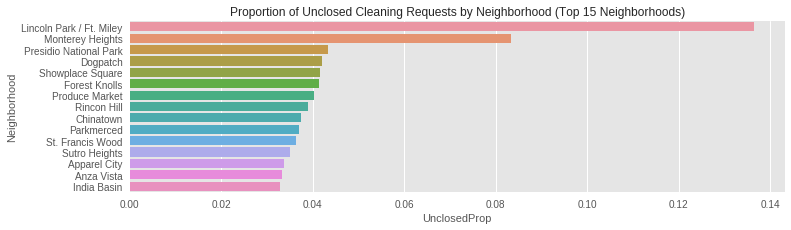

In [15]:
sns.set_context("notebook", rc={"font.size" : 40}) # font_scale=1.5
ax = sns.factorplot(x = "UnclosedProp", 
                    y = "Neighborhood",
                    data = counts.sort_values(by = "UnclosedProp",
                                              ascending = False).head(15), 
                    kind = "bar", 
                    orient = "h", 
                    aspect = 3
                   )#, size = 10)
plt.title("Proportion of Unclosed Cleaning Requests by Neighborhood (Top 15 Neighborhoods)") 
plt.show()

Use supervisor district where there are too many neighborhoods. 

In [16]:
request_counts = street.groupby(by = "Request Type").count().reset_index().ix[:,["Request Type","CaseID"]].sort_values(by = "CaseID", ascending = False)
request_counts.head()

,Request Type,CaseID
1,Bulky Items,185982
5,General Cleaning,175753
15,Sidewalk_Cleaning,171590
6,Hazardous Materials,81547
8,Illegal_Dumping,44571


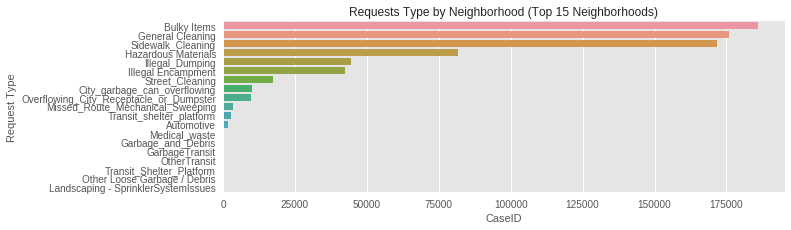

In [17]:
sns.set_context("notebook", rc={"font.size" : 40}) # font_scale=1.5
ax = sns.factorplot(y = "Request Type", 
                    x = "CaseID",
                    data = request_counts, 
                    kind = "bar", 
                    orient = "h", 
                    aspect = 3
                   )#, size = 10)
plt.title("Requests Type by Neighborhood (Top 15 Neighborhoods)") 
plt.show()

Differences by time of year:
- Mattresses in summer  
- Holiday shopping  


Note: only use 2009 through 2016 to only count full years.  
Ask TA if we should do this for all analysis or just this part.

In [18]:
street['month'] = [timestamp.month for timestamp in street.Opened]

In [19]:
street.head()

,CaseID,Opened,Closed,Status,Responsible Agency,Address,Category,Request Type,Request Details,Source,Supervisor District,Neighborhood,Updated,Point,month
0,322566,2008-11-30 22:56:00,2009-07-21 16:24:00,Closed,DPW Ops Queue,"1566 HYDE ST, SAN FRANCISCO, CA, 94109",Street and Sidewalk Cleaning,Sidewalk_Cleaning,Garbage,Voice In,3.0,Nob Hill,2009-07-21 16:24:00,"(37.795328529, -122.418067787)",11
1,322560,2008-11-30 22:24:00,2009-07-21 16:24:00,Closed,DPW Ops Queue,Intersection of TAYLOR ST and TURK ST,Street and Sidewalk Cleaning,Illegal_Dumping,Garbage,Voice In,6.0,Downtown/Civic Center,2009-07-21 16:24:00,"(37.7832142923006, -122.410764953722)",11
2,322559,2008-11-30 22:20:00,2008-12-01 06:07:00,Closed,DPW Ops Queue,"1601 SACRAMENTO ST, SAN FRANCISCO, CA, 94109",Street and Sidewalk Cleaning,Illegal_Dumping,Mattress,Voice In,3.0,Nob Hill,2008-12-01 06:07:00,"(37.791643509125, -122.419260423291)",11
3,322556,2008-11-30 21:34:00,2008-12-09 08:07:00,Closed,DPW Ops Queue,Intersection of 25TH ST and LUCKY ST,Street and Sidewalk Cleaning,Sidewalk_Cleaning,Human_waste_or_urine,Voice In,9.0,Mission,2008-12-09 08:07:00,"(37.7509362479361, -122.413364630104)",11
4,322545,2008-11-30 20:45:00,2009-02-03 07:09:00,Closed,DPW Ops Queue,Intersection of 19TH ST and OAKWOOD ST,Street and Sidewalk Cleaning,Sidewalk_Cleaning,Empty_cart,Voice In,8.0,Mission,2009-02-03 07:09:00,"(37.7598935230725, -122.42486308879)",11


In [20]:
count_by_month = street.groupby(by='month').count().CaseID.reset_index()
count_by_month

,month,CaseID
0,1,75185
1,2,61798
2,3,50527
3,4,48875
4,5,52543
5,6,57559
6,7,64272
7,8,69850
8,9,68477
9,10,69697


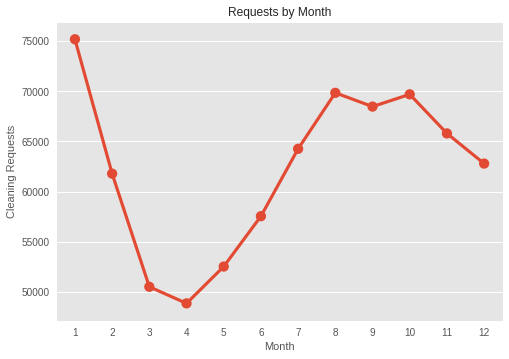

In [21]:
sns.set_context("notebook", rc={"font.size" : 40}) # font_scale=1.5
ax = sns.pointplot(y = "CaseID", 
                    x = "month",
                    data = count_by_month, 
                    kind = "bar", 
                    aspect = 3,
                   )#, size = 10)
ax.set_ylabel("Cleaning Requests")
ax.set_xlabel("Month")
plt.title("Requests by Month") 
plt.show()

Faster at closing requests by time?
Time to close requests by neighborhood?

# Scraping

In [22]:
requests_cache.install_cache('sf_cache')

In [23]:
url = "http://www.city-data.com/nbmaps/neigh-San-Francisco-California.html"
response = requests.get(url)
response.raise_for_status

neighborhoods_bs = BeautifulSoup(response.text, 'lxml')

neighborhood_names = neighborhoods_bs.find_all(name = "span", attrs={'class':'street-name'})

In [24]:
neighborhood_names = [name.text for name in neighborhood_names]

In [25]:
neighborhood_names

[u'Alamo Square',
 u'Anza Vista',
 u'Aquatic Park',
 u'Baja Noe',
 u'Balboa Park',
 u'Balboa Terrace',
 u'Bayview District',
 u'Bayview Heights',
 u'Bernal Heights',
 u'Bernal Heights North',
 u'Bernal Heights Park',
 u'Bernal Heights South',
 u'Buena Vista Park',
 u'Castro',
 u'Cathedral Hill',
 u'Cayuga Terrace',
 u'Central Richmond',
 u'Central Sunset',
 u'Chinatown',
 u'Civic Center',
 u'Clarendon Heights',
 u'Cole Valley',
 u'Corona Heights',
 u'Cow Hollow',
 u'Crocker-Amazon',
 u'Deco Ghetto',
 u'Diamond Heights',
 u'Dogpatch',
 u'Downtown',
 u'Duboce Triangle',
 u'Embarcadero',
 u'Excelsior',
 u'Financial District',
 u'Financial District South',
 u"Fisherman's Wharf",
 u'Forest Hill',
 u'Forest Knolls',
 u'Fort Mason',
 u'French Quarter',
 u'Ghirardelli Square',
 u'Glen Park',
 u'Golden Gate Heights',
 u'Golden Gate Park',
 u'Haight-Ashbury',
 u'Hayes Valley',
 u'Holly Park',
 u'Hunters Point',
 u'India Basin',
 u'Ingleside',
 u'Ingleside Heights',
 u'Ingleside Terrace',
 u'Inne

In [26]:
neighborhood_divs = neighborhoods_bs.body.find_all(name = "div", attrs={'class':'neighborhood'})

In [27]:
neighborhood_divs[0].text

u"Alamo Square neighborhood in San Francisco statistics: (Find on map)\nArea: 0.144 square milesPopulation: 6,379Population density:Alamo Square:44,418 people per square mileSan Francisco:18,521 people per square mileMedian household income in 2015: Alamo Square:$93,901San Francisco:$92,094Median rent in in 2015: Alamo Square:$1,754San Francisco:$1,609Male vs FemalesMales:3,916Females:2,461Median ageMales:35.4 yearsFemales:38.6 yearsHousing prices:Average estimated value of detached houses in 2015 (4.9% of all units):Alamo Square:$1,988,926San Francisco:$1,134,589Average estimated value of townhouses or other attached units in 2015 (1.6% of all units):This neighborhood:$948,534city:$846,333Average estimated value of housing units in 2-unit structures in 2015 (9.8% of all units):This neighborhood:$1,003,276San Francisco:$1,001,026Average estimated '15 value of housing units in 3-to-4-unit structures (26.8% of all units):Alamo Square:$736,205city:$984,108Average estimated '15 value of ho

regular expressions
[capital letter][lowercase][:][ ][numbers or , or $]

In [28]:
neighborhood_divs[0].find_all(name = "b")

[<b>Area:</b>,
 <b>square miles</b>,
 <b>Population:</b>,
 <b>Population density:</b>,
 <b>Alamo Square:</b>,
 <b>people per square mile</b>,
 <b>San Francisco:</b>,
 <b>people per square mile</b>,
 <b>Median household income in 2015: </b>,
 <b>Alamo Square:</b>,
 <b>San Francisco:</b>,
 <b>Median rent in in 2015: </b>,
 <b>Alamo Square:</b>,
 <b>San Francisco:</b>,
 <b>Male vs Females</b>,
 <b>Males:</b>,
 <b>Females:</b>,
 <b>Median age</b>,
 <b>Males:</b>,
 <b>Females:</b>,
 <b>Housing prices:</b>,
 <b>Average estimated value of detached houses in 2015 </b>,
 <b>:</b>,
 <b>Alamo Square:</b>,
 <b>San Francisco:</b>,
 <b>Average estimated value of townhouses or other attached units in 2015 </b>,
 <b>:</b>,
 <b>This neighborhood:</b>,
 <b>city:</b>,
 <b>Average estimated value of housing units in 2-unit structures in 2015 </b>,
 <b>:</b>,
 <b>This neighborhood:</b>,
 <b>San Francisco:</b>,
 <b>Average estimated '15 value of housing units in 3-to-4-unit structures </b>,
 <b>:</b>,
 <b>A

In [29]:
neighborhood_divs[0].contents

[<strong><span class="street-name">Alamo Square</span> neighborhood in San Francisco statistics: </strong>,
 u'(',
 <a href="javascript:sm(103);">Find on map</a>,
 u')',
 <br/>,
 <br/>,
 u'\n',
 <b>Area:</b>,
 u' 0.144 ',
 <b>square miles</b>,
 <br/>,
 <br/>,
 <b>Population:</b>,
 u' 6,379',
 <br/>,
 <br/>,
 <b>Population density:</b>,
 <br/>,
 <div class="hgraph"><table><tr><td><b>Alamo Square:</b></td><td><p class="h" style="padding-left:150px;"></p>44,418 <b>people per square mile</b></td></tr><tr><td><b>San Francisco:</b></td><td><p class="a" style="padding-left:62px;"></p>18,521 <b>people per square mile</b></td></tr></table></div>,
 <br/>,
 <b>Median household income in 2015: </b>,
 <br/>,
 <div class="hgraph"><table><tr><td><b>Alamo Square:</b></td><td><p class="h" style="padding-left:150px;"></p>$93,901</td></tr><tr><td><b>San Francisco:</b></td><td><p class="a" style="padding-left:147px;"></p>$92,094</td></tr></table></div>,
 <br/>,
 <b>Median rent in in 2015: </b>,
 <br/>,
 <

In [30]:
type(neighborhood_divs[0].contents[1])

bs4.element.NavigableString

Loop through contents  
if a navigable string can be converted to int,  
then grab it and the first <b> that precedes it  

In [31]:
neighborhood_divs[0].strings

<generator object _all_strings at 0x7f6e47a34140>

In [32]:
# Add to a list of strings
strings = []

for descendant in neighborhood_divs[0].strings:
    strings.append(descendant)
    
strings

[u'Alamo Square',
 u' neighborhood in San Francisco statistics: ',
 u'(',
 u'Find on map',
 u')',
 u'\n',
 u'Area:',
 u' 0.144 ',
 u'square miles',
 u'Population:',
 u' 6,379',
 u'Population density:',
 u'Alamo Square:',
 u'44,418 ',
 u'people per square mile',
 u'San Francisco:',
 u'18,521 ',
 u'people per square mile',
 u'Median household income in 2015: ',
 u'Alamo Square:',
 u'$93,901',
 u'San Francisco:',
 u'$92,094',
 u'Median rent in in 2015: ',
 u'Alamo Square:',
 u'$1,754',
 u'San Francisco:',
 u'$1,609',
 u'Male vs Females',
 u'Males:',
 u'3,916',
 u'Females:',
 u'2,461',
 u'Median age',
 u'Males:',
 u'35.4 years',
 u'Females:',
 u'38.6 years',
 u'Housing prices:',
 u'Average estimated value of detached houses in 2015 ',
 u'(4.9% of all units)',
 u':',
 u'Alamo Square:',
 u'$1,988,926',
 u'San Francisco:',
 u'$1,134,589',
 u'Average estimated value of townhouses or other attached units in 2015 ',
 u'(1.6% of all units)',
 u':',
 u'This neighborhood:',
 u'$948,534',
 u'city:',

In [33]:
#contents = neighborhood_divs[0].contents

value_dict_list = []

# Replace $
for i in range(1, len(strings)):
    if len(strings[i]) > 0:
        if strings[i][0] == '$':
            strings[i] = strings[i][1:]
        # remove commas and whitespace
        strings[i] = strings[i].replace(',', '').strip()

        try:
            value = float(strings[i])
            try:
                # what the value refers to
                what_value_is = strings[i - 1]
                
                # units
                if strings[i + 1][-1] != ":":
                    units = strings[i + 1]
                else:
                    units = ""
                
                value_dict = {"value": value,
                              "what_value_is": what_value_is,
                              "units": units}
                
                value_dict_list.append(value_dict)
                
            except:
                print "bad idea"

        except ValueError:
            continue
            
value_dict_list

[{'units': u'square miles', 'value': 0.144, 'what_value_is': u'Area:'},
 {'units': '', 'value': 6379.0, 'what_value_is': u'Population:'},
 {'units': u'people per square mile',
  'value': 44418.0,
  'what_value_is': u'Alamo Square:'},
 {'units': u'people per square mile',
  'value': 18521.0,
  'what_value_is': u'San Francisco:'},
 {'units': '', 'value': 93901.0, 'what_value_is': u'Alamo Square:'},
 {'units': u'Median rent in in 2015: ',
  'value': 92094.0,
  'what_value_is': u'San Francisco:'},
 {'units': '', 'value': 1754.0, 'what_value_is': u'Alamo Square:'},
 {'units': u'Male vs Females',
  'value': 1609.0,
  'what_value_is': u'San Francisco:'},
 {'units': '', 'value': 3916.0, 'what_value_is': u'Males:'},
 {'units': u'Median age', 'value': 2461.0, 'what_value_is': u'Females:'},
 {'units': '', 'value': 1988926.0, 'what_value_is': u'Alamo Square:'},
 {'units': u'Average estimated value of townhouses or other attached units in 2015 ',
  'value': 1134589.0,
  'what_value_is': u'San Franc

In [34]:
strings

[u'Alamo Square',
 u'neighborhood in San Francisco statistics:',
 u'(',
 u'Find on map',
 u')',
 u'',
 u'Area:',
 u'0.144',
 u'square miles',
 u'Population:',
 u'6379',
 u'Population density:',
 u'Alamo Square:',
 u'44418',
 u'people per square mile',
 u'San Francisco:',
 u'18521',
 u'people per square mile',
 u'Median household income in 2015:',
 u'Alamo Square:',
 u'93901',
 u'San Francisco:',
 u'92094',
 u'Median rent in in 2015:',
 u'Alamo Square:',
 u'1754',
 u'San Francisco:',
 u'1609',
 u'Male vs Females',
 u'Males:',
 u'3916',
 u'Females:',
 u'2461',
 u'Median age',
 u'Males:',
 u'35.4 years',
 u'Females:',
 u'38.6 years',
 u'Housing prices:',
 u'Average estimated value of detached houses in 2015',
 u'(4.9% of all units)',
 u':',
 u'Alamo Square:',
 u'1988926',
 u'San Francisco:',
 u'1134589',
 u'Average estimated value of townhouses or other attached units in 2015',
 u'(1.6% of all units)',
 u':',
 u'This neighborhood:',
 u'948534',
 u'city:',
 u'846333',
 u'Average estimated 

In [35]:
int("9,999")

ValueError: invalid literal for int() with base 10: '9,999'